## Multiclass Naive Bayes Cyberbullying Detection

Over the past couple decades, social media has exploded into a daily use product for many people. As younger generations use and grow up with social media more than ever, it's important to keep a healthy environment for kids to grow up in. Cyberbullying sometimes isn't as obvious as other forms of bullying as it takes place online rather than in the real world. It's time social media companies take cyberbullying seriously and develop systems to prevent harmful messages from being sent in the first place. Below is a look at one sort of beginner solution using word processing and the Naive Bayes algorithm to try to classify cyberbullying on Twitter.

**Note: Due to the nature of the subject matter, this data set includes many examples of very harmful language.**

**Data set:** https://www.kaggle.com/datasets/andrewmvd/cyberbullying-classification



In [1]:
import numpy as np
import pandas as pd
import os
import nltk

#The commented out lines below were needed to download the appropriate resources for nltk on my system.
#You may need to uncomment these lines to run this notebook on your system.

#nltk.download('punkt')
#nltk.download('averaged_perceptron_tagger')
#nltk.download('wordnet')
#nltk.download('universal_tagset')
#nltk.download('stopwords')

In [2]:
df = pd.read_csv('./cyberbullying_tweets.csv')

df

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying
...,...,...
47687,"Black ppl aren't expected to do anything, depe...",ethnicity
47688,Turner did not withhold his disappointment. Tu...,ethnicity
47689,I swear to God. This dumb nigger bitch. I have...,ethnicity
47690,Yea fuck you RT @therealexel: IF YOURE A NIGGE...,ethnicity


In [3]:
#Printing the initial distribution of the dataset
for element in np.unique(df['cyberbullying_type']):
    print(element, list(df['cyberbullying_type']).count(element)/df.shape[0])

age 0.16757527467919148
ethnicity 0.16692527048561603
gender 0.16717688501216138
not_cyberbullying 0.16658978445022227
other_cyberbullying 0.1640317034303447
religion 0.16770108194246414


In [4]:
#Split data into training and testing data. Confirm train set is representative of the overall
from sklearn.model_selection import train_test_split
X = df['tweet_text']
y = df['cyberbullying_type']
initProb = {}
  
# using the train test split function
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=23, test_size=0.20, shuffle=True, stratify=y)

for element in np.unique(y_train):
    initProb[element] = list(y_train).count(element)/len(y_train)
    print(element, initProb[element])

age 0.16758839409744974
ethnicity 0.1669331376300684
gender 0.1671690299583257
not_cyberbullying 0.16659240426703012
other_cyberbullying 0.1640237989148953
religion 0.16769323513223075


In [5]:
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import defaultdict
from nltk.corpus import wordnet as wn

#Preprocess data by removing irrelevent words (from the stop list), special characters, and numbers.
#Also converts known words to the lemmatized version to create less words in the dictionary and align similar words

tag_map = defaultdict(lambda : wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV
tag_map['S'] = wn.ADJ_SAT

def preprocess(tweet):
    final = []
    #Lowercase all words
    tweet = tweet.lower()
    #tokenize tweet
    word_Lemmatized = WordNetLemmatizer()
    tweet = word_tokenize(tweet)
    for word, tag in pos_tag(tweet):
        #Removes words from the stop list and nonalpha words
        if word not in stopwords.words('english') and word.isalpha():
            #uses lemmatize to break words down into their other forms
            final.append(word_Lemmatized.lemmatize(word, tag_map[tag[0]]))
    return final

In [6]:
#Before
X_train

43006    @II_Tombstone_II wow fuck you faggot im never ...
35699    girls who bullied me in high school are bolts ...
1696     Lol every time my phone rings i keep thinking ...
38010    My high school years were shit. I was the “fat...
25632    RAWR. Still sad over the fact that seungie lik...
                               ...                        
27444    hashtag nachoshield hashtag goobergrape http:/...
1940     @ShinoGraphy Thanks for the correction. The se...
9184               @g0ssipsquirrelx Take a guess...what %?
23170    @buttercupashby @MaDaSaHaTtEr_17 The fact is t...
3579     Never understood how people can do ikea flat p...
Name: tweet_text, Length: 38153, dtype: object

In [7]:
#word lists for each classification category 

words = []; age_words = []; ethnicity_words = []; gender_words = []; religion_words = []; other_words = []; not_words = []

for ind in X_train.index:
    #applies preprocess function to all tweets
    X_train.loc[ind] = preprocess(X_train[ind])
    for word in X_train.loc[ind]:
        words.append(word)
        if y_train.loc[ind] == "age":
            age_words.append(word)
        elif y_train.loc[ind] == "ethnicity":
            ethnicity_words.append(word)
        elif y_train.loc[ind] == "gender":
            gender_words.append(word)
        elif y_train.loc[ind] == "religion":
            religion_words.append(word)
        elif y_train.loc[ind] == "other_cyberbullying":
            other_words.append(word)
        else:
            not_words.append(word)

#creates list of unique words in the train set
unique_words = list(dict.fromkeys(words))

#creates dictionaries to keep track of word frequency in each category
age_dict = dict.fromkeys(unique_words, 0); ethnicity_dict = dict.fromkeys(unique_words, 0)
gender_dict = dict.fromkeys(unique_words, 0); religion_dict = dict.fromkeys(unique_words, 0)
other_dict = dict.fromkeys(unique_words, 0); not_dict = dict.fromkeys(unique_words, 0)

for ind in X_train.index:
    for word in X_train.loc[ind]:
        if y_train.loc[ind] == "age":
            age_dict[word] += 1
        elif y_train.loc[ind] == "ethnicity":
            ethnicity_dict[word] += 1
        elif y_train.loc[ind] == "gender":
            gender_dict[word] += 1
        elif y_train.loc[ind] == "religion":
            religion_dict[word] += 1
        elif y_train.loc[ind] == "other_cyberbullying":
            other_dict[word] += 1
        else:
            not_dict[word] += 1

#number of words in each list
num_unique_words = len(unique_words)
num_age_words = len(age_words)
num_ethnicity_words = len(ethnicity_words)
num_gender_words = len(gender_words)
num_religion_words = len(religion_words)
num_other_words = len(other_words)
num_not_words = len(not_words)

#After
print(num_unique_words)
X_train

37522


43006    [wow, fuck, faggot, im, never, cute, ever, dum...
35699    [girl, bully, high, school, bolt, im, greta, v...
1696     [lol, every, time, phone, ring, keep, think, s...
38010    [high, school, year, shit, fat, girl, big, tit...
25632    [rawr, still, sad, fact, seungie, like, noona,...
                               ...                        
27444    [hashtag, nachoshield, hashtag, goobergrape, h...
1940     [shinography, thanks, correction, sentence, wi...
9184                                         [take, guess]
23170    [buttercupashby, fact, mohammed, every, bit, v...
3579     [never, understood, people, ikea, flat, pack, ...
Name: tweet_text, Length: 38153, dtype: object

In [8]:
#LaPlace smoothing and calculates the Bayes probability for each unique word in the training set
smoothing = 1
prob_age = dict.fromkeys(unique_words, 0)
prob_ethnicity = dict.fromkeys(unique_words, 0)
prob_gender = dict.fromkeys(unique_words, 0)
prob_religion = dict.fromkeys(unique_words, 0)
prob_other = dict.fromkeys(unique_words, 0)
prob_not = dict.fromkeys(unique_words, 0)

for word in unique_words:
        prob_age[word] = (age_dict[word] + smoothing) / (num_age_words + smoothing * num_unique_words)
        prob_ethnicity[word] = (ethnicity_dict[word] + smoothing) / (num_ethnicity_words + smoothing * num_unique_words)
        prob_gender[word] = (gender_dict[word] + smoothing) / (num_gender_words + smoothing * num_unique_words)
        prob_religion[word] = (religion_dict[word] + smoothing) / (num_religion_words + smoothing * num_unique_words)
        prob_other[word] = (other_dict[word] + smoothing) / (num_other_words + smoothing * num_unique_words)
        prob_not[word] = (not_dict[word] + smoothing) / (num_not_words + smoothing * num_unique_words)

In [9]:
#Classification of the testing set 
new_probs = initProb.copy()
classified = []
i = 0
for ind in X_test.index:
    #applies the same preprocessing as in the testing set
    X_test.loc[ind] = preprocess(X_test[ind])
    #initializes bayes probability to the initial distribution of the train set
    new_probs = initProb.copy()
    for word in X_test.loc[ind]:
        #ignores words not in training set due to no prior data
        if word in unique_words:
            new_probs["age"] *= prob_age[word]
            new_probs["ethnicity"] *= prob_ethnicity[word]
            new_probs["gender"] *= prob_gender[word]
            new_probs["not_cyberbullying"] *= prob_not[word]
            new_probs["other_cyberbullying"] *= prob_other[word]
            new_probs["religion"] *= prob_religion[word]
        #Solves slight underflow issue where so long tweets result in an underflow
        while new_probs[min(new_probs, key= lambda x: new_probs[x])] < 1:
            for key in new_probs.keys():
                new_probs[key] *= 10
    #appends most likely classification
    classified.append(max(new_probs, key= lambda x: new_probs[x]))
    i +=1

In [10]:
#Calculates accuracy score of the classifier
from sklearn import metrics
import itertools

score = metrics.accuracy_score(list(y_test), classified)
print("Accuracy: ", score)

cm = metrics.confusion_matrix(list(y_test), classified)

Accuracy:  0.7781738127686341


[Text(0, 0.5, 'age'),
 Text(0, 1.5, 'ethnicity'),
 Text(0, 2.5, 'gender'),
 Text(0, 3.5, 'not'),
 Text(0, 4.5, 'other'),
 Text(0, 5.5, 'religion')]

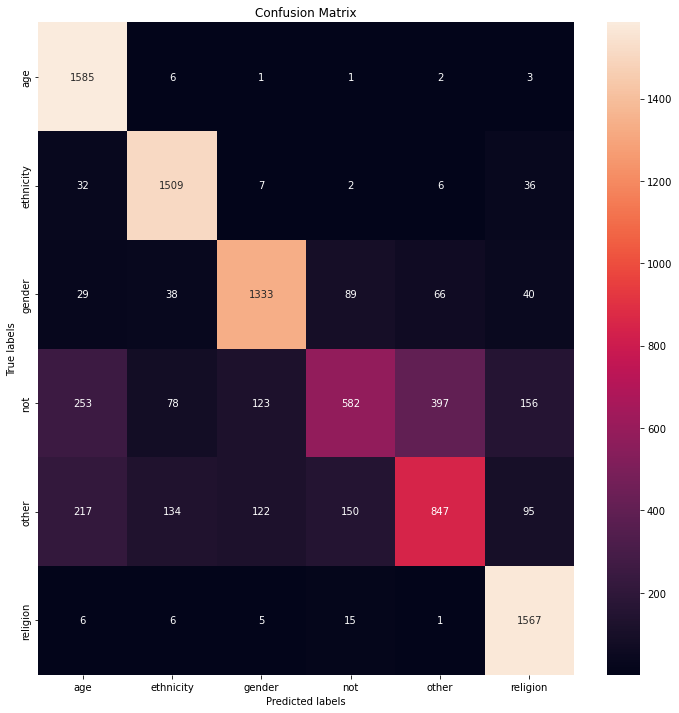

In [11]:
#Creates confusion matrix of classifier
import seaborn as sns
import matplotlib.pyplot as plt     
plt.figure(figsize=(12, 12))
ax = plt.subplot()

sns.heatmap(cm, annot=True, fmt='g', ax=ax)

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix') 
ax.xaxis.set_ticklabels(['age', 'ethnicity', 'gender', 'not', 'other', 'religion'])
ax.yaxis.set_ticklabels(['age', 'ethnicity', 'gender', 'not', 'other', 'religion'])

In [12]:
#Counts the frequency of every word in the training dataset
from collections import Counter

word_counter = Counter(words)
word_counter

Counter({'wow': 223,
         'fuck': 5832,
         'faggot': 88,
         'im': 612,
         'never': 1222,
         'cute': 101,
         'ever': 650,
         'dumb': 4292,
         'bitch': 2012,
         'nigger': 4561,
         'asshole': 158,
         'scritch': 1,
         'girl': 4393,
         'bully': 8556,
         'high': 4119,
         'school': 7295,
         'bolt': 4,
         'greta': 6,
         'von': 3,
         'yeet': 1,
         'lol': 884,
         'every': 779,
         'time': 1460,
         'phone': 104,
         'ring': 34,
         'keep': 581,
         'think': 2358,
         'year': 1113,
         'shit': 1260,
         'fat': 292,
         'big': 516,
         'tit': 18,
         'tease': 27,
         'young': 209,
         'class': 357,
         'skip': 22,
         'lose': 257,
         'confidence': 27,
         'mum': 42,
         'die': 298,
         'end': 360,
         'average': 29,
         'definitely': 137,
         'best': 354,
         'l

In [13]:
#Removes infrequent words where they occur only once
for key in list(word_counter):
    if word_counter[key] < 2:
        del word_counter[key]

word_counter

Counter({'wow': 223,
         'fuck': 5832,
         'faggot': 88,
         'im': 612,
         'never': 1222,
         'cute': 101,
         'ever': 650,
         'dumb': 4292,
         'bitch': 2012,
         'nigger': 4561,
         'asshole': 158,
         'girl': 4393,
         'bully': 8556,
         'high': 4119,
         'school': 7295,
         'bolt': 4,
         'greta': 6,
         'von': 3,
         'lol': 884,
         'every': 779,
         'time': 1460,
         'phone': 104,
         'ring': 34,
         'keep': 581,
         'think': 2358,
         'year': 1113,
         'shit': 1260,
         'fat': 292,
         'big': 516,
         'tit': 18,
         'tease': 27,
         'young': 209,
         'class': 357,
         'skip': 22,
         'lose': 257,
         'confidence': 27,
         'mum': 42,
         'die': 298,
         'end': 360,
         'average': 29,
         'definitely': 137,
         'best': 354,
         'life': 863,
         'rawr': 2,
         'st

In [14]:
#creates list of unique words in the train set
unique_words = list(dict.fromkeys(word_counter))
print(len(unique_words))

#creates dictionaries to keep track of word frequency in each category
age_dict = dict.fromkeys(unique_words, 0); ethnicity_dict = dict.fromkeys(unique_words, 0)
gender_dict = dict.fromkeys(unique_words, 0); religion_dict = dict.fromkeys(unique_words, 0)
other_dict = dict.fromkeys(unique_words, 0); not_dict = dict.fromkeys(unique_words, 0)

for ind in X_train.index:
    for word in X_train.loc[ind]:
        if word in unique_words:
            if y_train.loc[ind] == "age":
                age_dict[word] += 1
            elif y_train.loc[ind] == "ethnicity":
                ethnicity_dict[word] += 1
            elif y_train.loc[ind] == "gender":
                gender_dict[word] += 1
            elif y_train.loc[ind] == "religion":
                religion_dict[word] += 1
            elif y_train.loc[ind] == "other_cyberbullying":
                other_dict[word] += 1
            else:
                not_dict[word] += 1

#number of words in each list
num_unique_words = len(unique_words)
num_age_words = len(age_words)
num_ethnicity_words = len(ethnicity_words)
num_gender_words = len(gender_words)
num_religion_words = len(religion_words)
num_other_words = len(other_words)
num_not_words = len(not_words)


15628


In [15]:
#LaPlace smoothing and calculates the Bayes probability for each unique word in the training set
smoothing = 1
prob_age = dict.fromkeys(unique_words, 0)
prob_ethnicity = dict.fromkeys(unique_words, 0)
prob_gender = dict.fromkeys(unique_words, 0)
prob_religion = dict.fromkeys(unique_words, 0)
prob_other = dict.fromkeys(unique_words, 0)
prob_not = dict.fromkeys(unique_words, 0)

for word in unique_words:
        prob_age[word] = (age_dict[word] + smoothing) / (num_age_words + smoothing * num_unique_words)
        prob_ethnicity[word] = (ethnicity_dict[word] + smoothing) / (num_ethnicity_words + smoothing * num_unique_words)
        prob_gender[word] = (gender_dict[word] + smoothing) / (num_gender_words + smoothing * num_unique_words)
        prob_religion[word] = (religion_dict[word] + smoothing) / (num_religion_words + smoothing * num_unique_words)
        prob_other[word] = (other_dict[word] + smoothing) / (num_other_words + smoothing * num_unique_words)
        prob_not[word] = (not_dict[word] + smoothing) / (num_not_words + smoothing * num_unique_words)

In [16]:
#Classification of the testing set 
new_probs = initProb.copy()
classified = []
i = 0
for ind in X_test.index:
    #initializes bayes probability to the initial distribution of the train set
    new_probs = initProb.copy()
    for word in X_test.loc[ind]:
        #ignores words not in training set due to no prior data
        if word in unique_words:
            new_probs["age"] *= prob_age[word]
            new_probs["ethnicity"] *= prob_ethnicity[word]
            new_probs["gender"] *= prob_gender[word]
            new_probs["not_cyberbullying"] *= prob_not[word]
            new_probs["other_cyberbullying"] *= prob_other[word]
            new_probs["religion"] *= prob_religion[word]
        #Solves slight underflow issue where so long tweets result in an underflow
        while new_probs[min(new_probs, key= lambda x: new_probs[x])] < 1:
            for key in new_probs.keys():
                new_probs[key] *= 10
    #appends most likely classification
    classified.append(max(new_probs, key= lambda x: new_probs[x]))
    i +=1

In [17]:
#Calculates accuracy score of the classifier
from sklearn import metrics
import itertools

score = metrics.accuracy_score(list(y_test), classified)
print("Accuracy: ", score)

cm = metrics.confusion_matrix(list(y_test), classified)

Accuracy:  0.7890764231051473


[Text(0, 0.5, 'age'),
 Text(0, 1.5, 'ethnicity'),
 Text(0, 2.5, 'gender'),
 Text(0, 3.5, 'not'),
 Text(0, 4.5, 'other'),
 Text(0, 5.5, 'religion')]

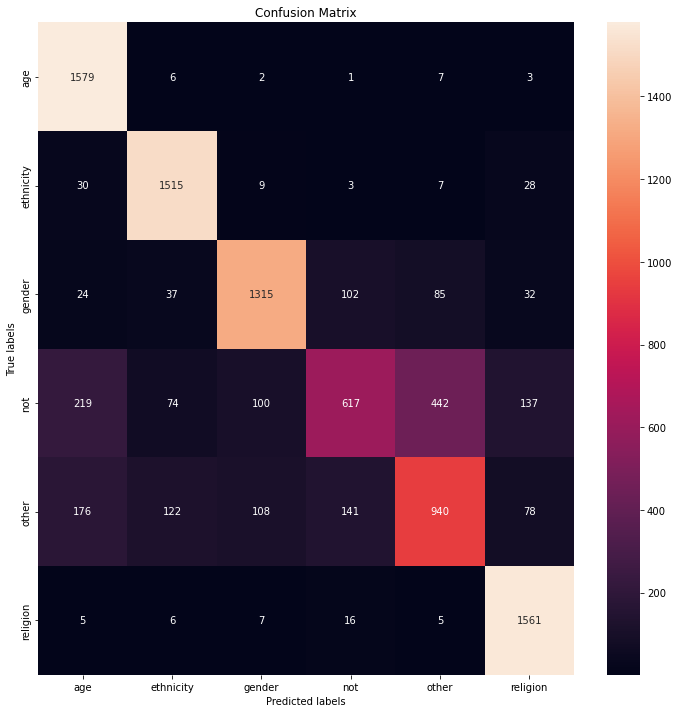

In [18]:
#Creates confusion matrix of classifier
import seaborn as sns
import matplotlib.pyplot as plt     
plt.figure(figsize=(12, 12))
ax = plt.subplot()

sns.heatmap(cm, annot=True, fmt='g', ax=ax)

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix') 
ax.xaxis.set_ticklabels(['age', 'ethnicity', 'gender', 'not', 'other', 'religion'])
ax.yaxis.set_ticklabels(['age', 'ethnicity', 'gender', 'not', 'other', 'religion'])